In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import math
import csv
import datetime
from copy import deepcopy
import dir_constants as dc
from tqdm import tqdm
from j_utils import munging as mg
from j_utils import eval_results as er
import lc_utils
import hyperlearn.hyperlearn.impute.SVDImpute as hpl_imp
import seaborn as sns
import pickle
from catboost import CatBoostClassifier, CatBoostRegressor, CatBoost, Pool, cv
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample
from timeit import default_timer as timer

# from fastai.structured import *

pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999
pd.options.display.max_seq_items = None
# np.set_printoptions(threshold=100)

Note that first time import of HyperLearn will be slow, since NUMBA code has to be compiled to machine code for optimization purposes.


In [4]:
# functions

def check_date_doneness(eval_loan_info):
    '''Every month, get all loans that were issued on or before month and ended on or after month (all loans that were alive during month, DENOMINATOR) and how many of those loans are still alive today (NUMERATOR, filter by status not in ['paid', 'charged_off', 'defaulted])'''
    dates = sorted(list(set(eval_loan_info['issue_d'].unique()).union(set(eval_loan_info['end_d'].unique()))))
    res_dict = {}
    for month in tqdm(dates):
        alive_cond = (eval_loan_info['issue_d'] <= month) & (eval_loan_info['end_d'] >= month)
        alive_in_month = eval_loan_info[alive_cond]
        still_going_today = alive_in_month[~alive_in_month['loan_status'].isin(['paid', 'defaulted', 'charged_off'])]
        res_dict[month] = len(still_going_today)/len(alive_in_month)
    return pd.Series(res_dict)

def get_returns(month_loans, loan_ids, target = '0.05'):
    '''
    given month_loans (eval_loan_info df) and loan ids, return mean returns
    '''
    return month_loans[month_loans['id'].isin(loan_ids)][target].mean()

def get_top_n_ids(df, score_name, n=100):
    '''
    Assuming that higher score = better, so you want higher score. Assuming that df has an id column.
    '''
    score_arr = df[score_name].values
    id_arr = df['id'].values
    
    if n < len(score_arr):
        ind = np.argpartition(score_arr, -n)[-n:]
        return id_arr[ind]
    else: # if the picked loans n is greater than existing loans, just return existing loans
        return id_arr

# load in data

In [5]:
PATH = dc.data_path
project = 'lendingclub'
fname_base_loan = 'base_loan_info.fth'
fname_eval_loan = 'eval_loan_info.fth'
fname_str_loan = 'str_loan_info.fth'
fname_scl_pmt = 'scaled_pmt_hist.fth'
data_path = f'{PATH}{project}'

In [6]:
# load in and drop fico low
base_loan_info = pd.read_feather(f'{data_path}/base_loan_info.fth')
base_loan_info.drop('fico_range_low', axis=1, inplace=True)
eval_loan_info = pd.read_feather(f'{data_path}/eval_loan_info.fth')
str_loan_info = pd.read_feather(f'{data_path}/str_loan_info.fth')
# base_loan_info = pd.read_feather(f'{data_path}/base_loan_info_w_newfeats.fth')

In [7]:
print(base_loan_info.shape)
lc_utils.add_custom_lc_features(base_loan_info)
print(base_loan_info.shape)

(2003915, 102)
(2003915, 107)


```
In this notebook I want to determine how I should evaluate models. Previously, I trained regressors on data to predict a npv_return on loans.
Things I want to determine:
1) Should I use ranking as a target? e.g. see loans in a batch, rank loans by known return, and then have model try and be good at ranking loans within batches?
1a) The final loan selection should probably determine a rank and regress a return, so we can still select a minimum score threshold that a loan must have a predicted return greater than before investing in it.
2) I want to do some sort of testing to see whether I should actually be training on all my data. Compare the following scenarios where "today" is a chosen date in the past and "prev" is a date older than "today":
    train on all past until today, test on everything in future (see how good past can predict future, pushing "today" more into the past will show us how good "old models" are still beyond their today)
    train on all past until today, test on sequential 3-mo periods in future (can show us if predictions get steadily worse as we move further and further past "today")
    train from prev until today, test on everything beyond today (see if its actually better to not use all the old data)
    train from prev until today, test on sequential 3-mo periods in future (more distinction between train on all data or train on relevant data)
```

# check "doneness" of loans at each month

100%|██████████| 138/138 [00:13<00:00,  9.92it/s]


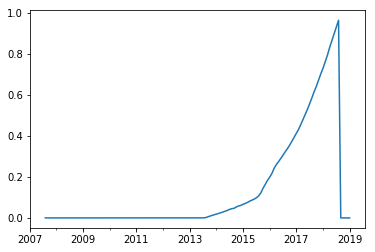

In [8]:
res = check_date_doneness(eval_loan_info=eval_loan_info)
res.plot()

In [9]:
# oldness_thrsh = .9
dates = sorted(list(set(eval_loan_info['issue_d'].unique()).union(set(eval_loan_info['end_d'].unique()))))
# start_date = '2011-01-01'

# extract the loans I can use for training/validating (loans that are "done enough")

In [10]:
base_loan_info, eval_loan_info = lc_utils.split_out_traintestable_loans(base_loan_info, eval_loan_info)

In [11]:
print(base_loan_info.shape, eval_loan_info.shape)

(1151168, 107) (1151168, 43)


# Do an example split, with train being everything before "today" and validation being everything after

In [12]:
today = pd.to_datetime('2013-01-01')
oldest = eval_loan_info['issue_d'].min()
valid_start = pd.to_datetime(today) + pd.DateOffset(months=1)
X_train, y_train_C, X_valid, y_valid_C, train_ids, valid_ids = lc_utils.gen_expt_datasets(today, oldest, valid_start, base_loan_info, eval_loan_info, target='target_strict')

In [13]:
_, y_train_R, _, y_valid_R, _, _ = lc_utils.gen_expt_datasets(today, oldest, valid_start, base_loan_info, eval_loan_info, target='0.05')

In [14]:
valid_dates = sorted(
                list(eval_loan_info[eval_loan_info['id'].isin(valid_ids)]['issue_d'].unique()))

In [15]:
# setup month_dfs
month_dfs = {}
for date in valid_dates:
    ids = eval_loan_info[eval_loan_info['issue_d'] == date]['id'].unique()
    month_dfs[date] = X_valid[X_valid['id'].isin(ids)]

# Various Models

In [16]:
import itertools

top_n = [10, 20, 30, 40, 50, 100, 1000]
eval_period = ['all', 'monthly']
trials = 30

In [17]:
# import already done models
all_df = pd.read_csv('all_baselines_df.csv', header=[0,1,2], index_col = 0)
monthly_df = pd.read_csv('monthly_baselines_df.csv', header=[0,1,2], index_col = 0)

In [71]:
cat_features = ['purpose', 'sub_grade', 'addr_state', 'is_inc_v', 'term', 'grade', 'emp_length', 'addr_zip', 'home_ownership', 'initial_list_status', 'earliest_cr_lineYear', 'earliest_cr_lineMonth', 'earliest_cr_lineWeek', 'earliest_cr_lineDayofweek', 'earliest_cr_lineDayofyear', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']

In [74]:
for feat in cat_features:
    X_train[feat] = X_train[feat].astype(int)
    X_valid[feat] = X_valid[feat].astype(int)

## Baselines

### Random choice and random choice by grade

In [33]:
# set up what I'm interseted in
model = [None, 1, 2, 3, 4, 5,]
# expt_params = {'top_n': top_n,
#                'eval_periiod': eval_period}
expt_params = list(itertools.product(eval_period, model))

In [34]:
def baseline_model(valid, grade=None):
    if grade:
        valid = valid[valid['grade'] == grade]
#     elif not grade:
#         grade = 'all_grades'
    scores = np.random.permutation(len(valid))
    valid['{0}_scores'.format(grade)] = scores/len(valid)
    return valid

In [35]:
# def timeer():
model_res = {}
for expt in tqdm(expt_params):
    eval_per, mod = expt
#     if eval_per == 'all':
    trial_res = {}
    for trial in range(trials):
        if eval_per == 'all':
            scored = baseline_model(X_valid, grade=mod)
    #             scored = scored.sort_values('{0}_scores'.format(mod), ascending=False)
            top_n_rets = {}
            for n in top_n:
                chosen_ids = get_top_n_ids(scored, '{0}_scores'.format(mod), n=n)
                n_rets = get_returns(eval_loan_info, chosen_ids)
                top_n_rets[n] = n_rets

        if eval_per == 'monthly':
            top_n_rets = {}
            for month, df in month_dfs.items():
                scored = baseline_model(df, grade=mod)
                month_top_n_rets = {}
                for n in top_n:
                    chosen_ids = get_top_n_ids(scored, '{0}_scores'.format(mod), n=n)
                    n_rets = get_returns(eval_loan_info, chosen_ids)
                    month_top_n_rets[n] = n_rets
                top_n_rets[month] = month_top_n_rets
        trial_res[trial] = top_n_rets
    #reshape trial_res
    if eval_per == 'monthly':
        for trial, indict in trial_res.items():
            trial_res[trial] = pd.DataFrame(indict).T.to_dict()
    trial_res = pd.DataFrame(trial_res).T.to_dict()
    for n, res in trial_res.items():
        model_res[(eval_per, mod, n)] = res

  8%|▊         | 1/12 [00:09<01:49,  9.92s/it]/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
100%|██████████| 12/12 [1:00:21<00:00, 525.47s/it]


In [36]:
baseline_model_res = model_res

In [37]:
# split out all vs monthly eval period from model_res
monthly_baselines = {}
all_baselines = {}
for k,v in model_res.items():
    if 'all' in k:
        all_baselines[k] = v
    else:
        monthly_baselines[k] = v

In [38]:
all_baselines_df = pd.DataFrame(all_baselines)
all_baselines_df.columns.set_names(['eval_period', 'model', 'top_n'], inplace=True)
all_baselines_df.to_csv('all_baselines_df.csv')

In [39]:
# all_baselines_df.mean().iloc[all_baselines_df.columns.get_level_values(2).isin([20,30,40,50,100])]
all_baselines_df.mean()

eval_period  model  top_n
all          NaN    10      -0.047379
                    20      -0.043509
                    30      -0.051069
                    40      -0.052720
                    50      -0.057280
                    100     -0.056031
                    1000    -0.049039
             1      10      -0.030780
                    20      -0.030527
                    30      -0.034180
                    40      -0.032249
                    50      -0.028202
                    100     -0.024181
                    1000    -0.019581
             2      10      -0.019354
                    20      -0.027603
                    30      -0.030178
                    40      -0.028387
                    50      -0.026368
                    100     -0.028202
                    1000    -0.025606
             3      10      -0.031084
                    20      -0.033245
                    30      -0.036549
                    40      -0.036304
                    50  

In [483]:
for k,v in monthly_baselines.items():
    monthly_baselines[k] = pd.DataFrame(v).mean(axis=1)

In [484]:
monthly_baselines_df = pd.DataFrame(monthly_baselines)
monthly_baselines_df.columns.set_names(['eval_period', 'model', 'top_n'], inplace=True)
monthly_baselines_df.to_csv('monthly_baselines_df.csv')

In [485]:
monthly_baselines_df.head()

eval_period   monthly                                                    \
model             NaN                                                     
top_n            10        20        30        40        50        100    
2013-02-01   0.043920  0.048330  0.046285  0.051171  0.050980  0.047910   
2013-03-01   0.034151  0.046826  0.050081  0.050708  0.046338  0.053054   
2013-04-01   0.050848  0.044044  0.042014  0.044613  0.042984  0.046799   
2013-05-01   0.063061  0.060120  0.063366  0.062297  0.062000  0.054370   
2013-06-01   0.034596  0.039104  0.043342  0.039802  0.042890  0.051825   

eval_period                                                              \
model                         1                                           
top_n            1000      10        20        30        40        50     
2013-02-01   0.049403  0.025023  0.025735  0.022833  0.021281  0.017559   
2013-03-01   0.055491  0.002731  0.013048  0.011393  0.010996  0.011970   
2013-04-01   0.052034  0.007150  0.010167  0.016690  0.020088  0.021066   
2013-05-01   0.058550  0.008329  0.003525  0.009276  0.010003  0.007709   
2013-06-01   0.055911  0.012167  0.017402  0.017194  0.017043  0.016423   

eval_period                                                              \
model                                   2                                 
top_n            100       1000      10        20        30        40     
2013-02-01   0.016167  0.016267  0.050477  0.050790  0.045819  0.043536   
2013-03-01   0.016204  0.015582  0.056034  0.050063  0.048384  0.049101   
2013-04-01   0.020566  0.022143  0.042288  0.043470  0.048162  0.048820   
2013-05-01   0.007173  0.011670  0.041644  0.043095  0.039982  0.038885   
2013-06-01   0.016516  0.018315  0.037005  0.035051  0.033878  0.039267   

eval_period                                                              \
model                                             3                       
top_n            50        100       1000      10        20        30     
2013-02-01   0.043693  0.042475  0.042926  0.071831  0.058456  0.063881   
2013-03-01   0.051901  0.047606  0.049392  0.069913  0.063734  0.054522   
2013-04-01   0.048440  0.046748  0.042058  0.086236  0.077265  0.079649   
2013-05-01   0.043366  0.046275  0.043672  0.071645  0.073404  0.078067   
2013-06-01   0.036956  0.041765  0.040439  0.030616  0.044480  0.046754   

eval_period                                                              \
model                                                       4             
top_n            40        50        100       1000      10        20     
2013-02-01   0.069445  0.070066  0.065543  0.067076  0.057805  0.052808   
2013-03-01   0.058854  0.065123  0.061347  0.066110  0.064195  0.065270   
2013-04-01   0.074636  0.072397  0.072314  0.067947  0.057505  0.057870   
2013-05-01   0.083987  0.078417  0.070968  0.065643  0.061441  0.059573   
2013-06-01   0.050783  0.054589  0.057157  0.065584  0.088421  0.078620   

eval_period                                                              \
model                                                                 5   
top_n            30        40        50        100       1000      10     
2013-02-01   0.061115  0.060519  0.058862  0.056173  0.055207  0.121350   
2013-03-01   0.066197  0.062135  0.055738  0.058082  0.061517  0.077310   
2013-04-01   0.057667  0.058076  0.061742  0.063441  0.065126  0.052100   
2013-05-01   0.051322  0.049107  0.054038  0.052167  0.056397  0.106226   
2013-06-01   0.077423  0.080087  0.078960  0.075395  0.072245  0.106529   

eval_period                                                              
model                                                                    
top_n            20        30        40        50        100       1000  
2013-02-01   0.115139  0.122470  0.114316  0.103870  0.090038  0.085462  
2013-03-01   0.106470  0.096734  0.103653  0.101228  0.093978  0.114058  
2013-04-01   0.063321  0

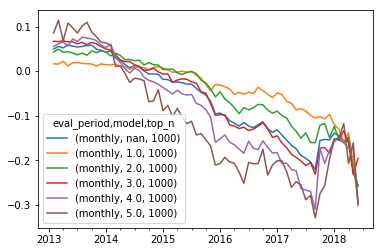

In [486]:
monthly_baselines_df.iloc[:,monthly_baselines_df.columns.get_level_values(2).isin([1000])].plot()

# Out of box params (for the most part) of the following

In [86]:
# setup scored (to do return comparison after all models built)
# also set up target_names list, specifying the col_name for each model's score
# in the scored df
# always want to choose highest scores, so for classifying, it predicts prob_not_def
scored = X_valid.copy()
target_names = []

In [227]:
print('If predicted everything as not defaulting: train acc: {0}, valid acc: {1}'.format(accuracy_np(y_train_C, np.zeros(len(y_train_C))),accuracy_np(y_valid_C, np.zeros(len(y_valid_C)))))

If predicted everything as not defaulting: train acc: 0.8001734402556783, valid acc: 0.7680334255568939


## SKlearn, Lasso (Reg) and Logistic (Class)

In [150]:
from sklearn import linear_model

In [151]:
lasso_R = linear_model.Lasso(alpha=0.1, normalize=True)
lasso_R.fit(X_train, y_train_R)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [152]:
scored['lasso_R'] = lasso_R.predict(X_valid)
target_names.append('lasso_R')

In [153]:
logistic_C = linear_model.LogisticRegression() # no normalize param?
logistic_C.fit(X_train, y_train_C)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [154]:
scored['logistic_C'] = logistic_C.predict_proba(X_valid)[:,0] #prob_not_def
target_names.append('logistic_C')

In [223]:
def accuracy_np(y, y_hat):
    if type(y) == pd.Series:
        y = y.values
    if type(y_hat) == pd.Series:
        y_hat = y_hat.values
    return (y == y_hat).sum()/len(y)

def plot_roc_auc(y, y_hat):
    fpr, tpr, thershold = roc_curve(y, y_hat)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def analyze_classifier(y, y_hat, classes):
    print('Accuracy: {0}'.format(accuracy_np(y, y_hat.round())))
    plot_roc_auc(y, y_hat)
    plot_confusion_matrix(confusion_matrix(y, y_hat.round()), classes)

In [224]:
from sklearn.metrics import roc_curve, auc
from j_utils.eval_results import confusion_matrix,plot_confusion_matrix

In [225]:
y, y_hat = y_train_C, 1-logistic_C.predict_proba(X_train)[:,0]
classes = ['not_default', 'default']

In [230]:
doc(fastai.core.Category)

In [236]:
from fastai.vision import *

In [237]:
doc(create_cnn)

In [232]:
test_cat = fastai.core.Category(1, 2)

In [234]:
test_cat.obj

2

Accuracy: 0.8001831840902669


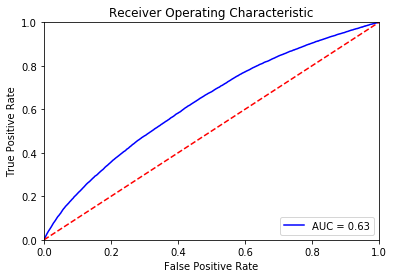

Confusion matrix, without normalization
[[82121     0]
 [20507     1]]


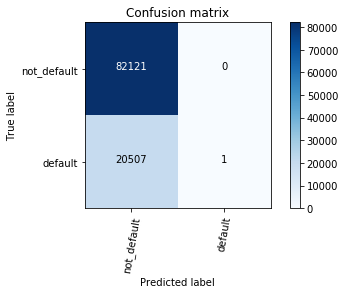

In [226]:
analyze_classifier(y, y_hat, classes)

## Various models via catboost, classification and regression postfix_C and _R mean classification and regression respectively

In [77]:
cat_features_idx = [X_train.columns.get_loc(col) for col in cat_features]

In [79]:
# constant parameters
params_C =  {}    
params_C['use_best_model'] = True
params_C['nan_mode'] = 'Forbidden'
params_C['early_stopping_rounds'] = 200
params_C['eval_metric'] = 'Logloss'
params_C['loss_function'] = 'Logloss'
params_C['task_type'] = 'GPU' # can't do custom loss function on GPU
params_C['verbose'] = False

params_R =  {}    
params_R['use_best_model'] = True
params_R['nan_mode'] = 'Forbidden'
params_R['early_stopping_rounds'] = 200
params_R['eval_metric'] = 'MAE'
params_R['loss_function'] = 'MAE'
params_R['l2_leaf_reg'] = 100
params_R['task_type'] = 'GPU' # can't do custom loss function on GPU
params_R['verbose'] = False

In [82]:
train_pool_C = Pool(X_train, y_train_C, cat_features=cat_features_idx)
test_pool_C = Pool(X_valid, y_valid_C, cat_features=cat_features_idx)

train_pool_R = Pool(X_train, y_train_R, cat_features=cat_features_idx)
test_pool_R = Pool(X_valid, y_valid_R, cat_features=cat_features_idx)

In [83]:
# trials don't matte; while predicted prob may differ slightly, catboost
# ends up choosing the same loans across trials
catboost_model_C = CatBoostClassifier(**params_C, cat_features=cat_features_idx)
catboost_model_C.fit(train_pool_C, eval_set=test_pool_C)

In [87]:
scored['catboost_C'] = catboost_model_C.predict_proba(X_valid)[:,0]
target_names.append('catboost_C')

In [88]:
catboost_model_R = CatBoostRegressor(**params_R)
catboost_model_R.fit(train_pool_R, eval_set=test_pool_R, verbose=False)

In [89]:
scored['catboost_R'] = 1 - catboost_model_R.predict(X_valid)
target_names.append('catboost_R')

## fastai

In [112]:
from fastai.tabular import *
from fastai import *

In [91]:
# make a dataset to fit fastai format
print(X_train.shape, X_valid.shape)
fastai_df = pd.concat([X_train, X_valid])
fastai_df.reset_index(drop=True, inplace=True)
valid_idx = fastai_df.index[-len(X_valid):]

(102629, 81) (1048539, 81)


In [92]:
fastai_df_C = fastai_df.copy()
fastai_df_R = fastai_df.copy()

In [117]:
fastai_df_C['target'] = np.concatenate([y_train_C, y_valid_C])
fastai_df_C['target'] = fastai_df_C['target'].astype(int)
fastai_df_R['target'] = np.concatenate([y_train_R, y_valid_R])

# have to turn to categorical so fastai doesn't complain
for col in cat_features:
    fastai_df_C[col] = fastai_df_C[col].astype('category')
    fastai_df_R[col] = fastai_df_R[col].astype('category')

In [118]:
path = os.getcwd()
procs = [Normalize]
dep_var = 'target'

In [119]:
data_C = TabularDataBunch.from_df(path, fastai_df_C, dep_var, valid_idx = valid_idx, procs=procs, cat_names = cat_features)
data_R = TabularDataBunch.from_df(path, fastai_df_R, dep_var, valid_idx = valid_idx, procs=procs, cat_names = cat_features)

In [145]:
learner_C = tabular_learner(data_C, layers=[200,100], metrics=accuracy, )

In [146]:
learner_C.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.467456,1.081303,0.767695


In [139]:
%debug

> /home/justin/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py(47)legacy_get_string()
     45             reduce = True
     46 
---> 47         if size_average and reduce:
     48             ret = 'elementwise_mean'
     49         elif reduce:

ipdb> size_average
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
ipdb> reduce
True
ipdb> u
> /home/justin/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py(15)__init__()
     13         super(_Loss, self).__init__()
     14         if size_average is not None or reduce is not None:
---> 15             self.reduction = _Reduction.legacy_get_string(size_average, reduce)
     16         else:
     17             self.reduction = reduction

ipdb> u
> /home/justin/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py(22)__init__

In [121]:
learner_C.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.472288,6.458530,0.399120


In [109]:
help(tabular_learner)

Help on function tabular_learner in module fastai.tabular.data:

tabular_learner(data:fastai.basic_data.DataBunch, layers:Collection[int], emb_szs:Dict[str, int]=None, metrics=None, ps:Collection[float]=None, emb_drop:float=0.0, y_range:Union[Tuple[float, float], NoneType]=None, use_bn:bool=True, **kwargs)
    Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params.



# compare returns of various models

In [18]:
def make_all_returns(scored, target, top_n, eval_loan_info):
    # for all
    all_res = {}
    for n in top_n:
        chosen_ids = get_top_n_ids(scored, target, n=n)
        n_ret = get_returns(eval_loan_info, chosen_ids)
        all_res[('all',n)] = n_ret
    return all_res

def make_monthly_returns(scored_month_dfs, target, top_n, eval_loan_info):
    # for monthly
    monthly_res = {}
    for date, df in scored_month_dfs.items():
        for n in top_n:
            chosen_ids = get_top_n_ids(df, target, n=n)
            n_ret = get_returns(eval_loan_info, chosen_ids)
            monthly_res[(date,n)] = n_ret
            
    return monthly_res

def make_scored_month_dfs(scored, eval_loan_info, valid_dates):
    # setup scored_month_dfs
    scored_month_dfs = {}
    for date in valid_dates:
        ids = eval_loan_info[eval_loan_info['issue_d'] == date]['id'].unique()
        scored_month_dfs[date] = scored[scored['id'].isin(ids)]
    return scored_month_dfs

In [19]:
scored_month_dfs = make_scored_month_dfs(scored, eval_loan_info, valid_dates)

NameError: name 'scored' is not defined

In [ ]:
model_res = {}
for target in tqdm(target_names):
    sub = {}
    sub['all'] = make_all_returns(scored, target, top_n, eval_loan_info)
    sub['monthly'] = make_monthly_returns(scored_month_dfs, target, top_n, eval_loan_info)
    model_res[target] = sub

In [ ]:
for model, model_r in model_res.items():
    # add all
    all_res = model_r['all']
    for tup, v in all_res.items():
        all_df[(tup[0], model, tup[1])] = v
    
    # add monthly
    monthly_res = model_r['monthly']
    reshaped_monthly_d = {}
    for ind_col, val in monthly_res.items():
        date = ind_col[0]
        col_n = str(ind_col[1])
        final_col = ('monthly', model, col_n)
        if final_col not in reshaped_monthly_d:
            reshaped_monthly_d[final_col] = {}
        reshaped_monthly_d[final_col][date] = val
    monthly_df = pd.merge(monthly_df, pd.DataFrame.from_dict(reshaped_monthly_d), left_index=True, right_index=True)

In [ ]:
all_df.head()

In [ ]:
eval_loan_info[eval_loan_info['id'].isin(valid_ids)]['0.05'].hist(bins=100)

In [ ]:
all_df.mean()

In [ ]:
monthly_df.head()

In [ ]:
monthly_df.iloc[:,monthly_df.columns.get_level_values(2).isin(['1000'])].plot()

In [28]:
fastai.__version__

'1.0.37'

In [29]:
fastai.__file__

'/home/justin/anaconda3/lib/python3.6/site-packages/fastai/__init__.py'

In [30]:
fastai??

## examine custome objective functions (on hold, examples unclear)

In [19]:
class LoglossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        exponents = []
        for index in range(len(approxes)):
            exponents.append(math.exp(approxes[index]))

        result = []
        for index in range(len(targets)):
            p = exponents[index] / (1 + exponents[index])
            der1 = (1 - p) if targets[index] > 0.0 else -p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result

In [20]:
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_valid, y_valid)

In [21]:
del params['loss_function']
# del params['rsm']

NameError: name 'params' is not defined

In [ ]:
# train_pool = Pool(TRAIN_FILE, column_description=CD_FILE)
# test_pool = Pool(TEST_FILE, column_description=CD_FILE)
# Initialize CatBoostClassifier with custom `loss_function`
model = CatBoostClassifier(loss_function=LoglossObjective(), **params, )

In [ ]:
# Fit model
model.fit(train_pool, eval_set=test_pool)

In [30]:
# Only prediction_type='RawFormulVal' allowed with custom `loss_function`
preds_raw = model.predict(test_pool, prediction_type='RawFormulaVal')

In [33]:
np.exp(preds_raw)

array([0.66867532, 0.11191073, 0.26363131, ..., 0.04856405, 0.06309869,
       0.16485766])

# testing hyperopt

In [113]:
# n_folds=3
# scores = cv(train_pool, params, fold_count=n_folds, verbose=False)

In [218]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

In [219]:
expt_results_path = 'expt_results'
os.makedirs(expt_results_path, exist_ok=True)

In [220]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

# File to save first results
out_file = 'catboost_trials_{0}.csv'.format(now)
out_file_path = os.path.join(expt_results_path, out_file)
of_connection = open(out_file_path, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['return', 'params', 'run_time'])
of_connection.close()

In [221]:
def objective(params): #n_folds=5, #, train_pool, valid_pool, X_valid, n_choose, eval_loan_info, out_file_path
    # set perma params
    params['use_best_model'] = True
    params['nan_mode'] = 'Forbidden'
    params['early_stopping_rounds'] = 200
    
    start = timer()
    
#     scores = cv(train_pool, params, fold_count=n_folds, verbose=False)
    clf = CatBoostClassifier(**params)
    clf.fit(train_pool, eval_set=valid_pool, verbose=False)
    valid_preds = clf.predict_proba(X_valid)
    valid_probas = pd.DataFrame(data = valid_preds[:,1], index = X_valid['id'].values, columns=['def_prob'])
    valid_probas = valid_probas.sort_values('def_prob')
    chosen_ids = valid_probas.index[:n_choose]
    
    run_time = timer() - start
    
#     loss = scores['test-Logloss-mean'].min()
    returns = get_returns(eval_loan_info, chosen_ids)
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file_path, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([returns, params, run_time])
    of_connection.close()
    
    return {'loss': 10-returns, 'params': params, 'run_time': run_time, 'status': STATUS_OK}

In [222]:
space = {
    'loss_function': hp.choice('loss_function', ['Logloss']), #eventually add yetirank?
    'eval_metric': hp.choice('eval_metric', ['Logloss', 'Accuracy']),   
    'iterations': hp.quniform('iterations', 200, 2000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(100)),
    'bagging_temperature': hp.loguniform('bagging_temperature', np.log(.1), np.log(10)),
    'random_strength': hp.loguniform('random_strength', np.log(.1), np.log(10)),
    'depth': hp.quniform('depth', 2, 8, 1),
    'rsm': hp.quniform('rsm', .05, 1, .05),
}

n_choose = 200

In [223]:
# # Create the learning rate
# learning_rate = {'learning_rate': hp.quniform('learning_rate', 0, 1, .1)}
# learning_rate_dist = []

# # Draw 10000 samples from the learning rate domain
# for _ in range(10000):
#     learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
# plt.figure(figsize = (8, 6))
# sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
# plt.title('Learning Rate Distribution', size = 18); 
# plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

In [224]:
example = sample(space)
example

{'bagging_temperature': 1.1063081458786865,
 'depth': 4.0,
 'eval_metric': 'Accuracy',
 'iterations': 1500.0,
 'l2_leaf_reg': 94.08574424994453,
 'learning_rate': 0.8844352934678887,
 'loss_function': 'Logloss',
 'random_strength': 0.18659033417780765,
 'rsm': 0.45}

In [225]:
tpe_algorithm = tpe.suggest

In [226]:
bayes_trials = Trials()

In [227]:
MAX_EVALS=100

more_params = {
    'params': params,
    'train_pool' : train_pool,
    'valid_pool' : valid_pool,
    'X_valid': X_valid,
    'n_choose': n_choose,
    'eval_loan_info': eval_loan_info,
    'out_file_path': out_file_path,
}

best = fmin(fn=objective, space=space, algo=tpe_algorithm, max_evals = MAX_EVALS, trials = bayes_trials, )

In [228]:
best

{'bagging_temperature': 7.675417253509794,
 'depth': 8.0,
 'eval_metric': 1,
 'iterations': 700.0,
 'l2_leaf_reg': 23.101609604086267,
 'learning_rate': 0.01173597598190136,
 'loss_function': 0,
 'random_strength': 0.35726379526385593,
 'rsm': 0.8500000000000001}

In [229]:
results = pd.read_csv(out_file_path)

In [230]:
results

,return,params,run_time
0,-0.012668,"{'bagging_temperature': 0.11841717157293417, '...",24.852470
1,-0.007758,"{'bagging_temperature': 2.0071825700575596, 'd...",24.176406
2,-0.003915,"{'bagging_temperature': 0.1361995768654472, 'd...",14.248803
3,-0.003239,"{'bagging_temperature': 5.047411870900727, 'de...",18.087726
4,-0.011918,"{'bagging_temperature': 0.11139516864047928, '...",16.956853
5,-0.019632,"{'bagging_temperature': 1.4912935493575112, 'd...",54.122950
6,-0.013698,"{'bagging_temperature': 1.5660008464491895, 'd...",20.362295
7,-0.009162,"{'bagging_temperature': 0.3826736522896468, 'd...",26.409150
8,-0.035205,"{'bagging_temperature': 4.184429620958705, 'de...",15.767118
9,-0.029545,"{'bagging_temperature': 5.775037845340544, 'de...",16.556596


In [233]:
top_5 = results.sort_values('return', ascending=False).head()

In [234]:
top_5

,return,params,run_time
93,0.021648,"{'bagging_temperature': 7.675417253509794, 'de...",18.591719
66,0.009588,"{'bagging_temperature': 0.5993345476601228, 'd...",13.990213
65,0.009588,"{'bagging_temperature': 0.6559952787135871, 'd...",13.735077
44,0.009588,"{'bagging_temperature': 0.40955825274177426, '...",14.199812
67,0.009588,"{'bagging_temperature': 0.6368479562550844, 'd...",13.905735


In [235]:
import ast

top_5_dict = {}
for i,dic in enumerate(top_5['params'].values):
    top_5_dict[i] = ast.literal_eval(dic)

In [236]:
top_5_params = {}
for param in top_5_dict[0].keys():
    values_list = []
    for k,v in top_5_dict.items():
        values_list.append(v[param])
    top_5_params[param] = values_list

In [255]:
top_5_params['rsm']

[0.8500000000000001,
 0.8500000000000001,
 0.8,
 0.8500000000000001,
 0.8500000000000001]

In [246]:
best

{'bagging_temperature': 7.675417253509794,
 'depth': 8.0,
 'eval_metric': 1,
 'iterations': 700.0,
 'l2_leaf_reg': 23.101609604086267,
 'learning_rate': 0.01173597598190136,
 'loss_function': 0,
 'random_strength': 0.35726379526385593,
 'rsm': 0.8500000000000001}

In [259]:
# .488 - 1.1313 bagging temperature
# noted that depth of 6 or 7 works best
# Logloss
# 1750-1950 trees
# 20.7-60.5 l2_leaf_reg
# .020 - .0348 learning_rate
# Logloss
# .559 - .648 random strength
# .2 - .4 rsm

best_params = best

In [260]:
with open('catboost_best_params_{0}.pkl'.format(now), 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

# starting tests  mentioned above

In [9]:
with open('catboost_best_params_{0}.pkl'.format(now), 'rb') as handle:
    best_params = pickle.load(handle)
    
best_params    

NameError: name 'now' is not defined

### ranking test

In [11]:
today = pd.to_datetime('2014-01-01')
oldest = eval_loan_info['issue_d'].min()
valid_start = pd.to_datetime(today) + pd.DateOffset(months=1)
X_train, y_train, X_valid, y_valid, train_ids, valid_ids = lc_utils.gen_expt_datasets(today, oldest, valid_start, base_loan_info, eval_loan_info, target='target_strict')

In [12]:
X_train_eval = eval_loan_info[eval_loan_info['id'].isin(train_ids)]
X_valid_eval = eval_loan_info[eval_loan_info['id'].isin(valid_ids)]

In [13]:
# to do ranking, we need a group id (equivalent to a query: issue_d) # can it be extended to all loans in month later?
# document (loan)
# ranking (which position is it, higher rank is better e.g sort by descending and then np.arange)

In [14]:
rankings = eval_loan_info.copy()
rankings = rankings.set_index('id', drop=False)

train_rankings = rankings.loc[train_ids]
train_rankings.sort_values('0.05', ascending=True, inplace = True)
train_rankings['rank'] = np.arange(len(train_rankings))/len(train_rankings)

valid_rankings = rankings.loc[valid_ids]
valid_rankings.sort_values('0.05', ascending=True, inplace = True)
valid_rankings['rank'] = np.arange(len(valid_rankings))/len(valid_rankings)

y_train = train_rankings['rank']
y_valid = valid_rankings['rank']

y_train = y_train.loc[X_train['id']]
y_valid = y_valid.loc[X_valid['id']]

In [15]:
def create_weights(df):
    '''
    Newer loans and higher ranked loans should carry more weight
    rank 0 is the worst, so you want full weight at rank 1
    rank domain is [0,1]: weight = 1/(1+e**(10(x-.6)))
   
    
    age 0 is more recent, so you want more weight at age 0
    age domain is [0,1]: weight = e**(age-1)
    '''
    df = df.copy()
    df = df.sort_values('issue_d')
    issue_ds = df['issue_d'].unique()
    issue_d_map = {}
    for i, d in enumerate(issue_ds):
        issue_d_map[d] = i
    df['age'] = df['issue_d'].map(issue_d_map)
    df['group'] = df['age']
    df['age'] = df['age']/df['age'].max()
    rank_weight = np.exp(df['rank']-1)
    age_weight = 1/(1+np.exp(20*(-df['age']+.5)))
    
    comp_weight = rank_weight * age_weight
    
    # create groups
    
    
    return comp_weight.values, df['group'].values

In [16]:
train_weights, train_groups = create_weights(train_rankings)

In [27]:
test_groups = np.ones(len(y_valid)) + train_groups.max()

In [29]:
train_pool = Pool(X_train, y_train, group_id = train_groups, group_weight=train_weights)
valid_pool = Pool(X_valid, y_valid, group_id = test_groups) # unweighted on purpose

In [54]:
# param = {'loss_function':'PairLogit',
#          'learning_rate': .00001,
#          'iterations': 1000,
#          'depth': 7,
#          'use_best_model':True,
#          'bagging_temperature' : .7, }

# ranker = CatBoost(param)
# ranker.fit(train_pool, eval_set=valid_pool, verbose=True)


default_parameters = {
    'iterations': 500,
    'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10'],
    'verbose': False,
    'random_seed': 0,
    'task_type': 'GPU',
    'use_best_model': True
}

parameters = {}

In [55]:
def fit_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=valid_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoost(parameters)
    model.fit(train_pool, eval_set=valid_pool, plot=True)
    
    return model

In [56]:
model = fit_model('YetiRankPairwise', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [57]:
def get_preds(model, dataset, ids):
    preds = model.predict(dataset)
    return pd.DataFrame(list(zip(ids, preds)), columns=['id', 'predicted_rank'])

In [58]:
train_preds = get_preds(model, train_pool, train_ids)

In [67]:
valid_preds = get_preds(model, valid_pool, valid_ids)
valid_preds = valid_preds.sort_values('predicted_rank', ascending=False)

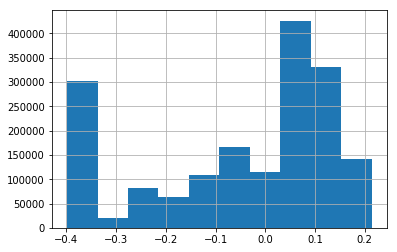

In [68]:
valid_preds['predicted_rank'].hist()

In [75]:
# check top 10 predicted from valid
rank_chosen_ids = valid_preds.head(10)['id']

In [76]:
get_returns(eval_loan_info, rank_chosen_ids)

0.011951793314196846

# Old stuff from baseline_models

In [ ]:
# Old stuff
# platform = 'lendingclub'

# store = pd.HDFStore(
#     '/Users/justinhsi/justin_tinkering/data_science/lendingclub/{0}_store.h5'.
#     format(platform),
#     append=True)

# test = store['test_filtered_columns']
# loan_npv_rois = store['loan_npv_rois']
# default_series = test['target_strict']

In [ ]:
def basic_models(trials, port_size, available_loans, grade, test,
                 loan_npv_rois, default_series):
    results = {}
    pct_default = {}
    if grade:
        test = test[test['grade'] == grade]
    for trial in tqdm_notebook(np.arange(trials)):
        loans_to_pick_from = np.random.choice(
            test.index.values, available_loans, replace=False)
        picks = np.random.choice(loans_to_pick_from, port_size, replace=False)
        results[trial] = loan_npv_rois.loc[picks, :].mean().to_dict()
        pct_default[trial] = (default_series.loc[picks].sum()) / port_size
    pct_default_series = pd.Series(pct_default)
    results_df = pd.DataFrame(results).T
    results_df['pct_def'] = pct_default_series
#     if not grade:
#         results_df = results_df.add_prefix('baseline_')
#     else:
#         results_df = results_df.add_prefix(grade + '_')
    if not grade:
        grade = 'baseline'
    results_df.columns = zip(results_df.columns.values,[grade]*len(results_df.columns.values))
    return results_df

In [ ]:
grades = [None]
grades.extend(test.grade.unique().tolist())
grades.sort()
grade_counts = test.grade.value_counts(dropna=False)

In [ ]:
trials = 20000
available_loans = 3000
grades_available_loans = [
    int(min(grade_counts[grade] * .2, available_loans))
    if grade else available_loans for grade in grades
]
grades_port_size = [int(.3*n_loans) for n_loans in grades_available_loans]
grade_batch_loans = dict(zip(grades, zip(grades_available_loans,grades_port_size)))

In [ ]:
grade_batch_loans

In [ ]:
grades_port_size

In [ ]:
results_dict = {}
for grade in tqdm_notebook(grades):
    results_dict[grade] = basic_models(trials, grade_batch_loans[grade][1],
                                       grade_batch_loans[grade][0], grade,
                                       test, loan_npv_rois, default_series)

In [ ]:
result = pd.concat(results_dict.values(), axis=1)
result.columns = pd.MultiIndex.from_tuples(
    result.columns.values, names=['discount_rate', 'model'])
result.sort_index(axis=1, inplace = True)

In [ ]:
result.describe()

In [ ]:
store.open()
store['results'] = result
store.close()